Load the LLM, in this case we are using gpt2

In [1]:
#!pip install transformers

In [2]:
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer

torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "gpt2"

tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True, add_prefix_space=True)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                            return_dict_in_generate=True,
                                            pad_token_id=tokenizer.eos_token_id).to(device)

In [3]:
import sys
sys.path.append("../")

In [4]:
from mini_relm_resources.automata_examples.man_woman_dfa import get_man_woman_automaton
automaton = get_man_woman_automaton()

In [5]:
alphabet = automaton.alphabet

In [6]:
from case_studies.gpt2.gpt2_probabilistic_model_wrapper import GPT2_probabilistic_model_wrapper
wrapper = GPT2_probabilistic_model_wrapper(50, alphabet, device, model, tokenizer)

In [7]:
from pythautomata.base_types.sequence import Sequence
test_seq = Sequence(["Hi","test", "test"])
test_seq

Hi,test,test

In [8]:
tokenizer.convert_tokens_to_ids(test_seq)

[17250, 9288, 9288]

In [9]:
from pymodelextractor.teachers.pac_probabilistic_teacher import PACProbabilisticTeacher
from pymodelextractor.learners.observation_tree_learners.bounded_pdfa_quantization_n_ary_tree_learner import BoundedPDFAQuantizationNAryTreeLearner
from pythautomata.utilities.probability_partitioner import TopKProbabilityPartitioner, QuantizationProbabilityPartitioner, RankingPartitioner
from pythautomata.model_comparators.wfa_partition_comparison_strategy import WFAPartitionComparator
from pythautomata.utilities.uniform_word_sequence_generator import UniformWordSequenceGenerator
partitioner = QuantizationProbabilityPartitioner(100)
comparator = WFAPartitionComparator(partitioner)
epsilon = 0.05
delta = epsilon
sequence_generator = UniformWordSequenceGenerator(alphabet, 50)
max_states = 100
max_query_length = 50


In [10]:
teacher  = PACProbabilisticTeacher(wrapper, epsilon = epsilon, delta = delta, max_seq_length = None, comparator = comparator, sequence_generator=sequence_generator, compute_epsilon_star=False)
learner = BoundedPDFAQuantizationNAryTreeLearner(partitioner, max_states, max_query_length, None, generate_partial_hipothesis = True, pre_cache_queries_for_building_hipothesis = True,  check_probabilistic_hipothesis = False)

In [11]:
learning_result = learner.learn(teacher)

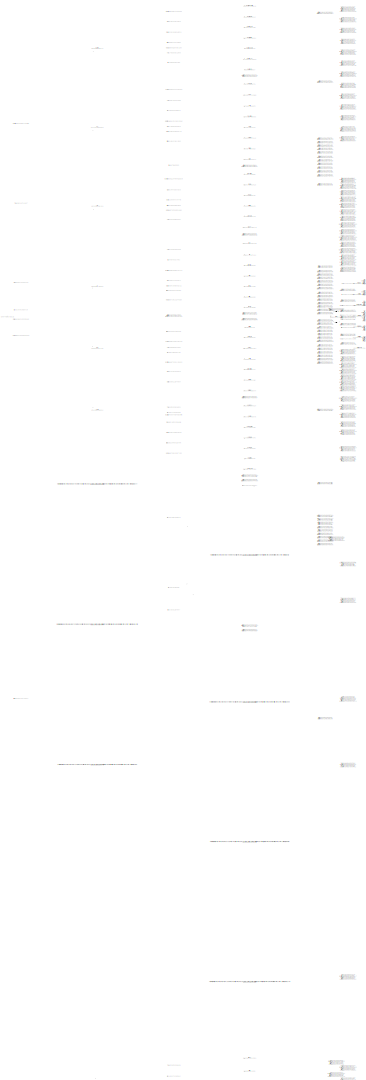

In [17]:
from pythautomata.model_exporters.dot_exporters.wfa_dot_exporting_strategy import WFADotExportingStrategy
import graphviz
from IPython.display import display

exporter = WFADotExportingStrategy()
graph = exporter.create_graph(learning_result.model)
graph.render(filename='graph_output', format='png', cleanup=True)

display(graph)